# Réalisation test entretien XEBIA

Ce notebook est un exercice de recrutement pour Xebia


Sujet : 

Bienvenue sur le marché de la tondeuse !!!

Notre client, Mower4u, souhaiterait mettre de nouveaux produits sur le marché et aurait besoin de votre aide pour l’assister dans sa prise de décision.

Son principal besoin consiste à estimer l’attractivité de chaque produit sur le marché. De cette attractivité dépend les futures parts de marché des produits étudiés.

Pour cela, il nous a fournit une capture du marché actuel des tondeuses en vente. 

In [1]:
%matplotlib inline
#Some Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pylab as py
import random
import math
import time


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm

from sklearn import tree
from sklearn import neighbors

from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error


In [2]:
#Importation des données
mower4u_df = pd.read_csv("mower_market_datasets/mower_market_snapshot.csv", sep=';')

print "Nb de données : ",len(mower4u_df)
print "Head des données:"
mower4u_df.head(10)

Nb de données :  1399
Head des données:


,capacity,failure_rate,id,margin,price,prod_cost,product_type,quality,warranty,market_share,attractiveness
0,10.492623,0.042528,18377,633.766584,828.802103,195.03551928211797,auto-portee,Low,3ans,0.006360,0.650648
1,20.273730,0.037896,19363,731.576817,882.894916,151.31809934886763,auto-portee,Low,3 ans.,0.006840,0.699792
2,20.190457,0.039111,19641,741.218202,919.355522,178.13731921134948,auto-portee,Low,3_ans,0.006179,0.632129
3,27.220131,0.041303,18728,654.255635,817.085097,162.82946157588628,auto-portee,Low,3 anss,0.007925,0.810730
4,16.370911,0.037938,18722,703.094527,844.581465,141.48693796090603,auto-portee,Medium,3ans.,0.007406,0.757614
5,19.548213,0.035428,18268,728.284617,905.297503,177.01288573033196,auto-portee,Medium,3 ans,0.007596,0.777051
6,12.242635,0.035492,18448,757.351286,930.615022,173.26373572791334,auto-portee,Hight,3_ans.,0.007488,0.766056
7,8.676314,0.042066,18943,633.515449,818.075591,184.56014118975136,auto-portee,Low,3 anss,0.005291,0.541318
8,15.264180,0.038804,19640,646.626567,816.774028,170.14746134881673,auto-portee,Low,3_ans.,0.006063,0.620278
9,16.190545,0.034045,19559,628.673360,814.799650,186.1262903279073,auto-portee,Low,3_ans.,0.005700,0.583117


Les données à disposition sont donc les suivantes:

* capacity : La capacité en litre du réservoir
* Failure_rate : le taux de panne
* id : id du produit
* margin : Marge effectué sur le produit (coût construction - prix vente)
* price : prix de vente
* prod_cost : coût de production
* product_type : type de marché
* quality : indice de qualité du produit
* warranty : Garenti du produit
* market_share : part de marché
* attractiveness : coefficient d'attractivité (cible et normalisation Market_share)


### Transformation des variable qualitative en quantitative


In [3]:
#Fonction qui vérifie c'est la valeur est bien un float
def is_number(s):
    try:
        float(s) 
        if s < 0 :
            return False
        else :
            return True
    except ValueError:
        return False

#Permet de transformer la variable de cout de production
def TransformProd_cost(cost):
    if is_number(cost):
        return float(cost)
    else :
        return np.nan
    
#Permet de transformer la variable de type de produit
def TransformProduct_type(prod_type):
    if prod_type == "auto-portee":
        return 1
    elif prod_type == "essence":
        return 2
    elif prod_type == "electrique":
        return 3
    else :
        return np.nan

#Fonction qui permet de transformer la variable de qualité
def TransformQuality(qual):
    if qual == "Low":
        return 1
    elif qual == "Medium":
        return 2
    elif qual == "Hight":
        return 3
    else :
        return np.nan
    
#Fonction qui permet de récupérer uniquement le nombre d'années de garentis
def TransformWarranty(warr):
    return int(warr[0])

mower4u_df['prod_cost'] = mower4u_df.prod_cost.apply(
               lambda x: (TransformProd_cost(x)))

mower4u_df['product_type'] = mower4u_df.product_type.apply(
               lambda x: (TransformProduct_type(x)))

mower4u_df['quality'] = mower4u_df.quality.apply(
               lambda x: (TransformQuality(x)))

mower4u_df['warranty'] = mower4u_df.warranty.apply(
               lambda x: (TransformWarranty(x)))


#On supprime enfin les exemples ou il y a des valeurs null
print "Taille data set avant enlevement des NaN valeurs :",len(mower4u_df)
mower4u_df = mower4u_df.dropna()
print "Taille data set apres enlevement des NaN valeurs :",len(mower4u_df)


Taille data set avant enlevement des NaN valeurs : 1399
Taille data set apres enlevement des NaN valeurs : 1368


In [4]:
mower4u_df.head(10)

,capacity,failure_rate,id,margin,price,prod_cost,product_type,quality,warranty,market_share,attractiveness
0,10.492623,0.042528,18377,633.766584,828.802103,195.035519,1,1,3,0.006360,0.650648
1,20.273730,0.037896,19363,731.576817,882.894916,151.318099,1,1,3,0.006840,0.699792
2,20.190457,0.039111,19641,741.218202,919.355522,178.137319,1,1,3,0.006179,0.632129
3,27.220131,0.041303,18728,654.255635,817.085097,162.829462,1,1,3,0.007925,0.810730
4,16.370911,0.037938,18722,703.094527,844.581465,141.486938,1,2,3,0.007406,0.757614
5,19.548213,0.035428,18268,728.284617,905.297503,177.012886,1,2,3,0.007596,0.777051
6,12.242635,0.035492,18448,757.351286,930.615022,173.263736,1,3,3,0.007488,0.766056
7,8.676314,0.042066,18943,633.515449,818.075591,184.560141,1,1,3,0.005291,0.541318
8,15.264180,0.038804,19640,646.626567,816.774028,170.147461,1,1,3,0.006063,0.620278
9,16.190545,0.034045,19559,628.673360,814.799650,186.126290,1,1,3,0.005700,0.583117


Une fois notre data set prêt et propre, nous allons pouvoir commancer à l'étudier.

Pour cela commençon par regarder simplement les attributs en fonction de notre valeur cible

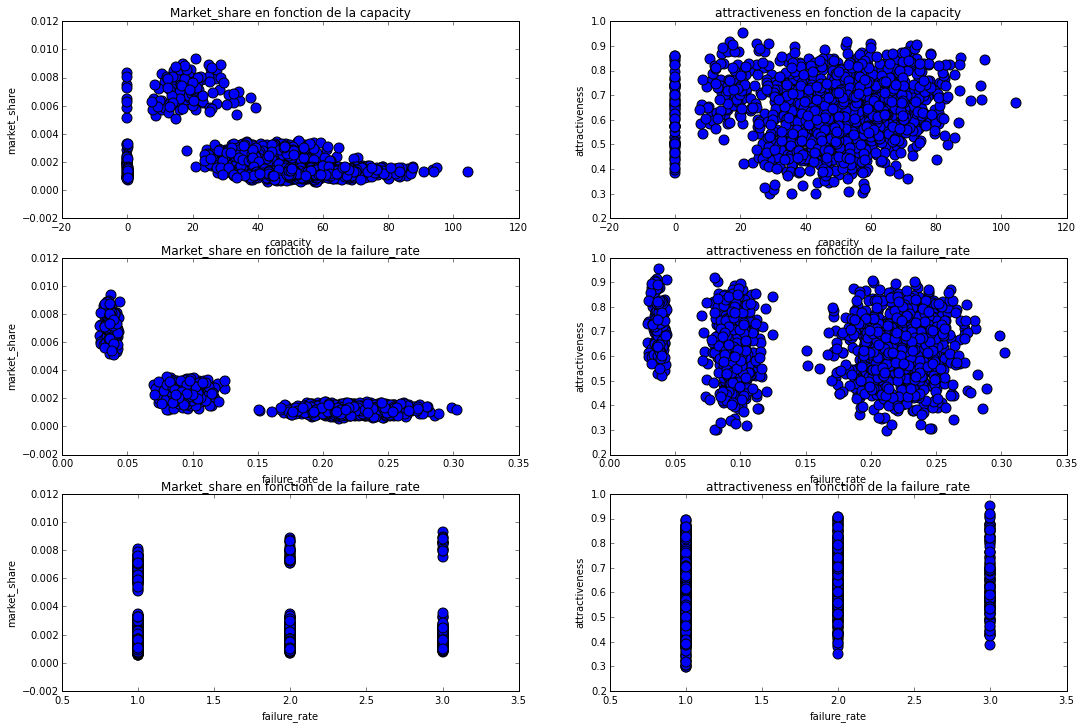

In [5]:
# specifies the parameters of our graphs
fig = plt.figure(figsize=(18,12), dpi=1600) 
alpha=alpha_scatterplot = 0.2 
alpha_bar_chart = 0.55


plt.subplot(321)
p1 = plt.scatter(mower4u_df["capacity"],mower4u_df["market_share"],s=100)
plt.title('Market_share en fonction de la capacity')
plt.xlabel('capacity')
plt.ylabel('market_share')

plt.subplot(322)
p1 = plt.scatter(mower4u_df["capacity"],mower4u_df["attractiveness"],s=100)
plt.title('attractiveness en fonction de la capacity')
plt.xlabel('capacity')
plt.ylabel('attractiveness')

plt.subplot(323)
p1 = plt.scatter(mower4u_df["failure_rate"],mower4u_df["market_share"],s=100)
plt.title('Market_share en fonction de la failure_rate')
plt.xlabel('failure_rate')
plt.ylabel('market_share')

plt.subplot(324)
p1 = plt.scatter(mower4u_df["failure_rate"],mower4u_df["attractiveness"],s=100)
plt.title('attractiveness en fonction de la failure_rate')
plt.xlabel('failure_rate')
plt.ylabel('attractiveness')

plt.subplot(325)
p1 = plt.scatter(mower4u_df["quality"],mower4u_df["market_share"],s=100)
plt.title('Market_share en fonction de la failure_rate')
plt.xlabel('failure_rate')
plt.ylabel('market_share')

plt.subplot(326)
p1 = plt.scatter(mower4u_df["quality"],mower4u_df["attractiveness"],s=100)
plt.title('attractiveness en fonction de la failure_rate')
plt.xlabel('failure_rate')
plt.ylabel('attractiveness')

On remarque bien que les données semble plus organisées et plus propice à l'utilisation de "Market_share" comme valeur cible.

Or dans notre étude, ce qu'il nous intéresse est est trouver la valeurs "Atractivenesse" qui est celon le sujet est une normalisation de la valeur "market_share"

Donc avant toute chose, nous devons trouver cette normalisation

### Recherche de la règle de normalisation

In [6]:
#Premier essai pour trouver la normalisation : Standard normalisation
description = mower4u_df.market_share.describe()
minimum = description['min']
maximum = description['max']

print "desc :",description
print "Max : ",maximum
print "Min : ",minimum

def standard_normalisation(x,maximum, minimum):
    return (x-minimum)/(maximum-minimum) #Normalisation standard
    #return x * (maximum - minimum) + minimum #Denormalisation

#Calcul test que l'on mettra dans un nouveau attribut appellé "test"
mower4u_df['test'] = mower4u_df.market_share.apply(
               lambda x: (standard_normalisation(x,maximum,minimum)))

desc : count    1368.000000
mean        0.002144
std         0.001790
min         0.000564
25%         0.001133
50%         0.001400
75%         0.002443
max         0.009314
Name: market_share, dtype: float64
Max :  0.00931430666362
Min :  0.000563646148601


In [7]:
mower4u_df.head(10)

,capacity,failure_rate,id,margin,price,prod_cost,product_type,quality,warranty,market_share,attractiveness,test
0,10.492623,0.042528,18377,633.766584,828.802103,195.035519,1,1,3,0.006360,0.650648,0.662395
1,20.273730,0.037896,19363,731.576817,882.894916,151.318099,1,1,3,0.006840,0.699792,0.717292
2,20.190457,0.039111,19641,741.218202,919.355522,178.137319,1,1,3,0.006179,0.632129,0.641708
3,27.220131,0.041303,18728,654.255635,817.085097,162.829462,1,1,3,0.007925,0.810730,0.841214
4,16.370911,0.037938,18722,703.094527,844.581465,141.486938,1,2,3,0.007406,0.757614,0.781882
5,19.548213,0.035428,18268,728.284617,905.297503,177.012886,1,2,3,0.007596,0.777051,0.803594
6,12.242635,0.035492,18448,757.351286,930.615022,173.263736,1,3,3,0.007488,0.766056,0.791311
7,8.676314,0.042066,18943,633.515449,818.075591,184.560141,1,1,3,0.005291,0.541318,0.540267
8,15.264180,0.038804,19640,646.626567,816.774028,170.147461,1,1,3,0.006063,0.620278,0.628470
9,16.190545,0.034045,19559,628.673360,814.799650,186.126290,1,1,3,0.005700,0.583117,0.586959


In [8]:
#Mise en place du calacul de root mean square Logirithme error
def rootMeanSquareError(TrueColumn, ComputeColumn):
    res = 0.
    for t in range(len(TrueColumn)):
        res += math.pow(math.log(ComputeColumn[t]+1) - math.log(TrueColumn[t]+1),2)
    res = res / len(TrueColumn)
    return math.sqrt(res)
    
print "rootMeanSquareError avec la standard normalisation :",rootMeanSquareError(mower4u_df['attractiveness'].values,mower4u_df['test'].values)
    

rootMeanSquareError avec la standard normalisation : 0.361935591597


L'erreur est très élevé, il faut donc trouver un autre moyen.

Pour cela nous allons afficher l'attractiveness en fonction du market_share

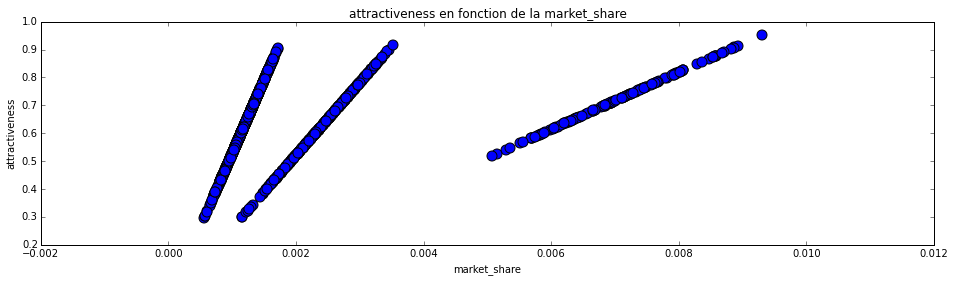

In [9]:
# specifies the parameters of our graphs
fig = plt.figure(figsize=(16,4), dpi=1600) 
alpha=alpha_scatterplot = 0.2 
alpha_bar_chart = 0.55

plt.subplot(111)
p3 = plt.scatter(mower4u_df["market_share"],mower4u_df["attractiveness"],s=100)
plt.title('attractiveness en fonction de la market_share')
plt.xlabel('market_share')
plt.ylabel('attractiveness')


On observe 3 amas de point qui ressemble à 3 droites que l'on suspecte apartenir aux différents types de produit.

Nous allons le vérifier en séparant le data set par type de produit et en affichant plus clairement le graphique précédent.

In [10]:
#Séparation du data set par type (micro-marchés)
mower4u_1_df = mower4u_df[mower4u_df["product_type"] == 1]
print "Element type 1 :",len(mower4u_1_df)

mower4u_2_df = mower4u_df[mower4u_df["product_type"] == 2]
print "Element type 2 :",len(mower4u_2_df)

mower4u_3_df = mower4u_df[mower4u_df["product_type"] == 3]
print "Element type 3 :",len(mower4u_3_df)

Element type 1 : 139
Element type 2 : 825
Element type 3 : 404


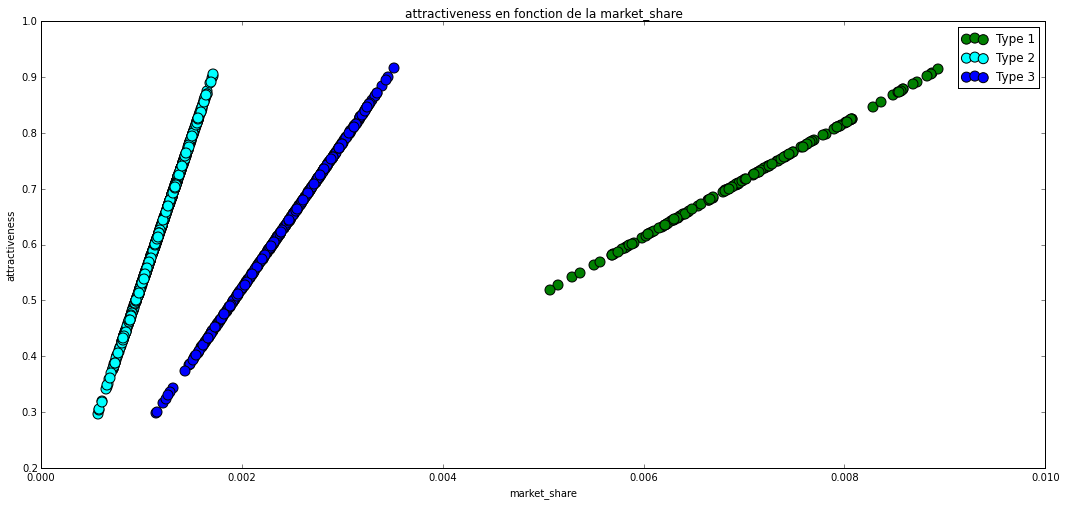

In [11]:
# specifies the parameters of our graphs
fig = plt.figure(figsize=(18,8), dpi=1600) 
alpha=alpha_scatterplot = 0.2 
alpha_bar_chart = 0.55

plt.subplot(111)
p1 = plt.scatter(mower4u_1_df["market_share"],mower4u_1_df["attractiveness"],s=100, c='green')
p2 = plt.scatter(mower4u_2_df["market_share"],mower4u_2_df["attractiveness"],s=100, c='cyan')
p3 = plt.scatter(mower4u_3_df["market_share"],mower4u_3_df["attractiveness"],s=100)
plt.title('attractiveness en fonction de la market_share')
plt.xlabel('market_share')
plt.ylabel('attractiveness')
plt.legend([p1,p2,p3],["Type 1","Type 2","Type 3"])


Cette fois-ci, nous pouvons confirmer que les regroupements par pseudo droites sont bien par type.

Alors, nous allons essayer de calculer l'équation de ces droites pour trouver les reglès de normalisation.

In [12]:
#Fonction qui calcul la tendance linéaire des données
def CalculTend(x,y):
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    print 'y=%.6fx+(%.6f)'%(z[0],z[1])
    return z

#On test pour chaque type de produit
list_norma_by_type = list()
list_norma_by_type.append(CalculTend(mower4u_1_df['market_share'].values,mower4u_1_df['attractiveness'].values))
list_norma_by_type.append(CalculTend(mower4u_2_df['market_share'].values,mower4u_2_df['attractiveness'].values))
list_norma_by_type.append(CalculTend(mower4u_3_df['market_share'].values,mower4u_3_df['attractiveness'].values))

#Fonction de normalisation via l'équation de la droite
def norma_by_type(row,z):
    x = row.get('market_share')
    t = row.get('product_type')
    return z[int(t)-1][0]*x+z[int(t)-1][1]
    
#Test pour confirmer la théorie
mower4u_df["test3"] = mower4u_df.apply(
    lambda row: (norma_by_type(row,list_norma_by_type)), axis=1)

print "rootMeanSquareError : ",rootMeanSquareError(mower4u_df['attractiveness'].values,mower4u_df["test3"].values)

y=102.302514x+(0.000000)
y=527.607446x+(0.000000)
y=260.563075x+(0.000000)
rootMeanSquareError :  1.67900740846e-16


Cette fois ci, nous avons une erreur de l'ordre de 10^{-16}, donc notre fonction de normalisation semble efficace.

Nous allons aisni pouvoir prédire la valeur de Market_share et ensuite pouvoir appliquer notre normalisation pour trouver l'attractiveness.

Mais avant de ce lancer "tête-baissé" dans la prédiction du market_share, observons un peu nos données

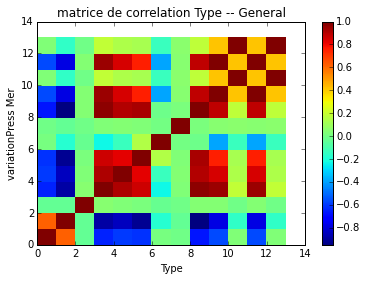

In [13]:
#Affichage de la matrice de corrélation
corr_matrix = mower4u_df.corr()
py.pcolor(corr_matrix)
py.colorbar()
plt.title('matrice de correlation Type -- General')
plt.xlabel('Type')
plt.ylabel('variationPress Mer')

### Plot data to understand

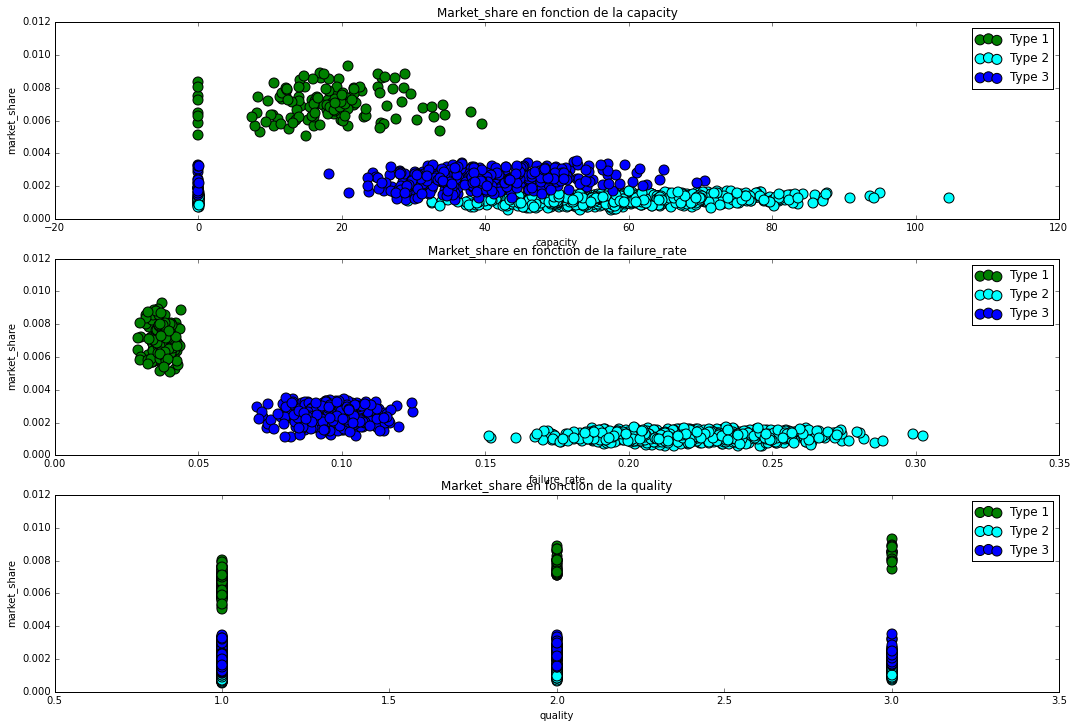

In [14]:
# specifies the parameters of our graphs
fig = plt.figure(figsize=(18,12), dpi=1600) 
alpha=alpha_scatterplot = 0.2 
alpha_bar_chart = 0.55


plt.subplot(311)
p1 = plt.scatter(mower4u_1_df["capacity"],mower4u_1_df["market_share"],s=100, c='green')
p2 = plt.scatter(mower4u_2_df["capacity"],mower4u_2_df["market_share"],s=100, c='cyan')
p3 = plt.scatter(mower4u_3_df["capacity"],mower4u_3_df["market_share"],s=100)
plt.title('Market_share en fonction de la capacity')
plt.xlabel('capacity')
plt.ylabel('market_share')
plt.legend([p1,p2,p3],["Type 1","Type 2","Type 3"])

plt.subplot(312)
p1 = plt.scatter(mower4u_1_df["failure_rate"],mower4u_1_df["market_share"],s=100, c='green')
p2 = plt.scatter(mower4u_2_df["failure_rate"],mower4u_2_df["market_share"],s=100, c='cyan')
p3 = plt.scatter(mower4u_3_df["failure_rate"],mower4u_3_df["market_share"],s=100)
plt.title('Market_share en fonction de la failure_rate')
plt.xlabel('failure_rate')
plt.ylabel('market_share')
plt.legend([p1,p2,p3],["Type 1","Type 2","Type 3"])

plt.subplot(313)
p1 = plt.scatter(mower4u_1_df["quality"],mower4u_1_df["market_share"],s=100, c='green')
p2 = plt.scatter(mower4u_2_df["quality"],mower4u_2_df["market_share"],s=100, c='cyan')
p3 = plt.scatter(mower4u_3_df["quality"],mower4u_3_df["market_share"],s=100)
plt.title('Market_share en fonction de la quality')
plt.xlabel('quality')
plt.ylabel('market_share')
plt.legend([p1,p2,p3],["Type 1","Type 2","Type 3"])

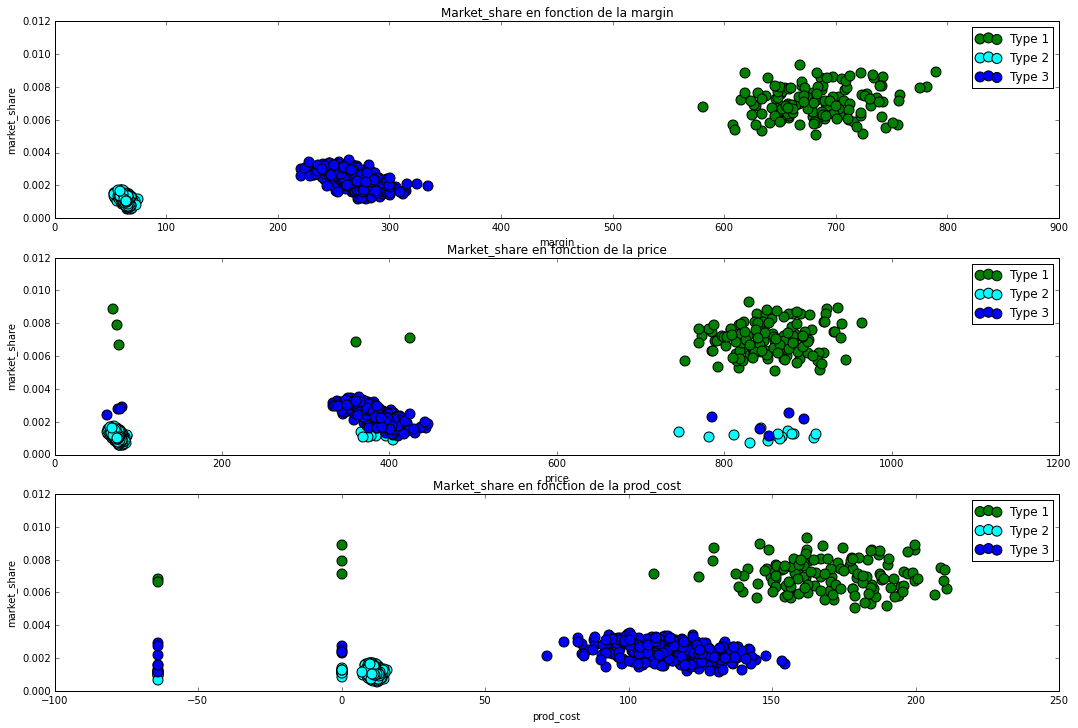

In [15]:
# specifies the parameters of our graphs
fig = plt.figure(figsize=(18,12), dpi=1600) 
alpha=alpha_scatterplot = 0.2 
alpha_bar_chart = 0.55


plt.subplot(311)
p1 = plt.scatter(mower4u_1_df["margin"],mower4u_1_df["market_share"],s=100, c='green')
p2 = plt.scatter(mower4u_2_df["margin"],mower4u_2_df["market_share"],s=100, c='cyan')
p3 = plt.scatter(mower4u_3_df["margin"],mower4u_3_df["market_share"],s=100)
plt.title('Market_share en fonction de la margin')
plt.xlabel('margin')
plt.ylabel('market_share')
plt.legend([p1,p2,p3],["Type 1","Type 2","Type 3"])


plt.subplot(312)
p1 = plt.scatter(mower4u_1_df["price"],mower4u_1_df["market_share"],s=100, c='green')
p2 = plt.scatter(mower4u_2_df["price"],mower4u_2_df["market_share"],s=100, c='cyan')
p3 = plt.scatter(mower4u_3_df["price"],mower4u_3_df["market_share"],s=100)
plt.title('Market_share en fonction de la price')
plt.xlabel('price')
plt.ylabel('market_share')
plt.legend([p1,p2,p3],["Type 1","Type 2","Type 3"])


plt.subplot(313)
p1 = plt.scatter(mower4u_1_df["prod_cost"],mower4u_1_df["market_share"],s=100, c='green')
p2 = plt.scatter(mower4u_2_df["prod_cost"],mower4u_2_df["market_share"],s=100, c='cyan')
p3 = plt.scatter(mower4u_3_df["prod_cost"],mower4u_3_df["market_share"],s=100)
plt.title('Market_share en fonction de la prod_cost')
plt.xlabel('prod_cost')
plt.ylabel('market_share')
plt.legend([p1,p2,p3],["Type 1","Type 2","Type 3"])



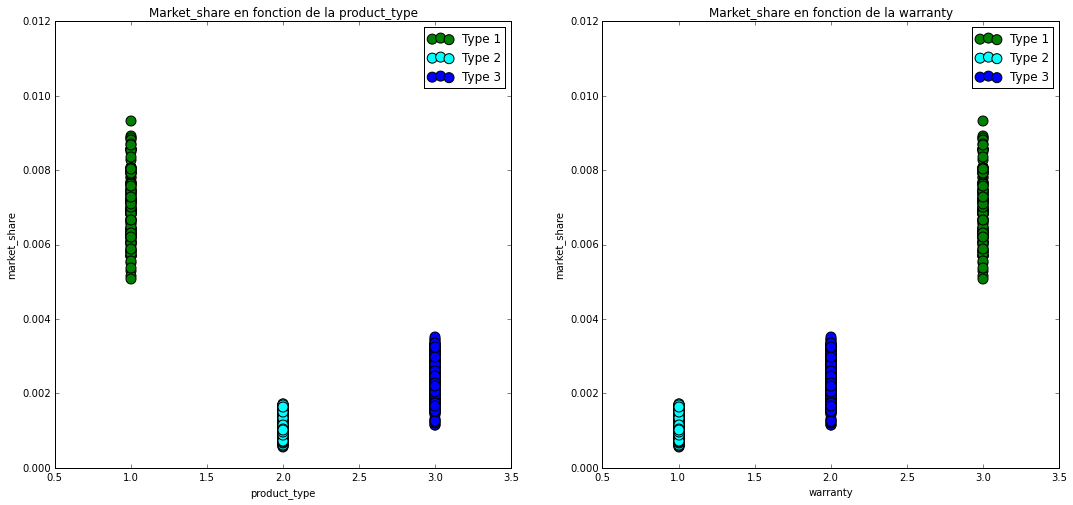

In [16]:
# specifies the parameters of our graphs
fig = plt.figure(figsize=(18,8), dpi=1600) 
alpha=alpha_scatterplot = 0.2 
alpha_bar_chart = 0.55

plt.subplot(121)
p1 = plt.scatter(mower4u_1_df["product_type"],mower4u_1_df["market_share"],s=100, c='green')
p2 = plt.scatter(mower4u_2_df["product_type"],mower4u_2_df["market_share"],s=100, c='cyan')
p3 = plt.scatter(mower4u_3_df["product_type"],mower4u_3_df["market_share"],s=100)
plt.title('Market_share en fonction de la product_type')
plt.xlabel('product_type')
plt.ylabel('market_share')
plt.legend([p1,p2,p3],["Type 1","Type 2","Type 3"])

plt.subplot(122)
p1 = plt.scatter(mower4u_1_df["warranty"],mower4u_1_df["market_share"],s=100, c='green')
p2 = plt.scatter(mower4u_2_df["warranty"],mower4u_2_df["market_share"],s=100, c='cyan')
p3 = plt.scatter(mower4u_3_df["warranty"],mower4u_3_df["market_share"],s=100)
plt.title('Market_share en fonction de la warranty')
plt.xlabel('warranty')
plt.ylabel('market_share')
plt.legend([p1,p2,p3],["Type 1","Type 2","Type 3"])


On peut observer que nos données sont assez regroupé par type de produit.

Ainsi, il nous reste à trouver le modèle qui va permettre de calculer la "Market_share"

### Some Machine learning

In [17]:
#On récupere toutes les features de calcules, on enleve les tests et ID
collist = [x for x in mower4u_df.columns if x not in ('market_share','attractiveness','test','id','test3')]

X = mower4u_df[collist].values
y = mower4u_df["market_share"].values

print "Il y a en tout %d observations dans le data set sur %d features" % X.shape
#print "Unique target labels:", np.unique(y)

Xr, Xt, yr, yt = train_test_split(X, y, random_state=0)
print "Learning size : ",len(Xr)
print "Testing size : ",len(Xt)

Il y a en tout 1368 observations dans le data set sur 8 features
Learning size :  1026
Testing size :  342


In [18]:
#Regression Linéaire
LR = LinearRegression(fit_intercept=True)

libLR_start=time.time()
LR.fit(Xr, yr)
libLR_train_end=time.time()
print "Apprentissage fini en : ",str(libLR_train_end-libLR_start)+" s"

y_pred_LR = np.array(LR.predict(Xt))
libLR_test_end=time.time()
print "Test fini en : ",str(libLR_test_end-libLR_train_end)+" s"

print "Erreur quadratique moyenne : ", mean_squared_error(yt, y_pred_LR)
print "RMSE : ",rootMeanSquareError(yt,y_pred_LR)

Apprentissage fini en :  0.140963077545 s
Test fini en :  0.00075888633728 s
Erreur quadratique moyenne :  2.06471917668e-07
RMSE :  0.000452047781893


In [19]:
#Knn
reg = neighbors.KNeighborsRegressor(5, weights='distance')#'uniform', 'distance'

libRFR_start=time.time()
reg.fit(Xr, yr)
libRFR_train_end=time.time()
print "Apprentissage fini en : ",str(libRFR_train_end-libRFR_start)+" s"

ypred_RF = reg.predict(Xt)
libRFR_test_end=time.time()
print "Test fini en : ",str(libRFR_test_end-libRFR_train_end)+" s"

print "Erreur quadratique moyenne : ",mean_squared_error(yt, ypred_RF)# reg.oob_score_
print "RMSE : ",rootMeanSquareError(yt,ypred_RF)

Apprentissage fini en :  0.00209021568298 s
Test fini en :  0.0063488483429 s
Erreur quadratique moyenne :  1.92895738784e-07
RMSE :  0.000436503997159


In [20]:
#Arbre de décision
reg = tree.DecisionTreeRegressor()

libRFR_start=time.time()
reg.fit(Xr, yr)
libRFR_train_end=time.time()
print "Apprentissage fini en : ",str(libRFR_train_end-libRFR_start)+" s"

ypred_RF = reg.predict(Xt)
libRFR_test_end=time.time()
print "Test fini en : ",str(libRFR_test_end-libRFR_train_end)+" s"

print "Erreur quadratique moyenne : ",mean_squared_error(yt, ypred_RF)# reg.oob_score_
print "RMSE : ",rootMeanSquareError(yt,ypred_RF)

Apprentissage fini en :  0.00915193557739 s
Test fini en :  0.00111508369446 s
Erreur quadratique moyenne :  1.32064982931e-07
RMSE :  0.000361603874776


In [21]:
#Random Forest
reg = RandomForestRegressor(n_estimators=500)

libRFR_start=time.time()
reg.fit(Xr, yr)
libRFR_train_end=time.time()
print "Apprentissage fini en : ",str(libRFR_train_end-libRFR_start)+" s"

ypred_RF = reg.predict(Xt)
libRFR_test_end=time.time()
print "Test fini en : ",str(libRFR_test_end-libRFR_train_end)+" s"

print "Erreur quadratique moyenne : ",mean_squared_error(yt, ypred_RF)# reg.oob_score_
print "RMSE : ",rootMeanSquareError(yt,ypred_RF)

Apprentissage fini en :  0.913791894913 s
Test fini en :  0.0117480754852 s
Erreur quadratique moyenne :  9.46011568404e-08
RMSE :  0.000306291938582


In [22]:
#SVN Regression
svR = svm.SVR()

libsvr_start=time.time()
svR.fit(Xr,yr)
libsvr_train_end=time.time()
print "Apprentissage fini en : ",str(libsvr_train_end-libsvr_start)+" s"

ypred_SVR = svR.predict(Xt)
libsvr_test_end=time.time()
print "Test réalisé en : ",str(libsvr_test_end-libsvr_train_end)+" s"

print "Erreur quadratique moyenne : ",mean_squared_error(yt, ypred_SVR)
print "RMSE :",rootMeanSquareError(yt,ypred_SVR)


Apprentissage fini en :  0.00088906288147 s
Test réalisé en :  0.000314950942993 s
Erreur quadratique moyenne :  9.74820204939e-06
RMSE : 0.00311198501495


L'erreur la plus faible est celle obtenue avec l'algorithme du Random Forest.

C'est ce que nous allons utiliser dans la suite.

## Calcul de la valeur sur le data set submission

In [23]:
#Extraction du fichier CSV
mower4u_test_df = pd.read_csv("mower_market_datasets/submission_set.csv", sep=';')

print "Nb de donnée : ",len(mower4u_test_df)
mower4u_test_df.head()

Nb de donnée :  600


,capacity,failure_rate,id,margin,price,prod_cost,product_type,quality,warranty
0,21.313064,0.037928,20049,613.061762,768.160605,155.098843,auto-portee,Medium,3 ans
1,25.797234,0.038664,19699,701.321608,865.727540,164.405932,auto-portee,Low,3 ans
2,14.314083,0.043118,19704,654.147498,807.374158,153.226660,auto-portee,Low,3 ans
3,29.754390,0.038551,20072,669.083239,866.573954,197.490715,auto-portee,Low,3 ans
4,24.915116,0.038829,20183,675.313221,859.205792,183.892571,auto-portee,Low,3 ans


In [24]:
#Transformation des variables comme fait pour le dataset snapshot

mower4u_test_df['prod_cost'] = mower4u_test_df.prod_cost.apply(
               lambda x: (TransformProd_cost(x)))

mower4u_test_df['product_type'] = mower4u_test_df.product_type.apply(
               lambda x: (TransformProduct_type(x)))

mower4u_test_df['quality'] = mower4u_test_df.quality.apply(
               lambda x: (TransformQuality(x)))

mower4u_test_df['warranty'] = mower4u_test_df.warranty.apply(
               lambda x: (TransformWarranty(x)))

print "Taille data set avant enlevement des NaN valeurs :",len(mower4u_test_df)
mower4u_test_df = mower4u_test_df.dropna()
print "Taille data set apres enlevement des NaN valeurs :",len(mower4u_test_df)

Taille data set avant enlevement des NaN valeurs : 600
Taille data set apres enlevement des NaN valeurs : 600


In [25]:
#Séparation du data set par type de produit
mower4u_test_1_df = mower4u_test_df[mower4u_test_df["product_type"] == 1].copy()
print "Element type 1 :",len(mower4u_test_1_df)

mower4u_test_2_df = mower4u_test_df[mower4u_test_df["product_type"] == 2].copy()
print "Element type 2 :",len(mower4u_test_2_df)

mower4u_test_3_df = mower4u_test_df[mower4u_test_df["product_type"] == 3].copy()
print "Element type 3 :",len(mower4u_test_3_df)

Element type 1 : 60
Element type 2 : 355
Element type 3 : 185


In [26]:
#Fonction de configuration pour synthétiser le code
def configureLearning(i):
    if int(i) == 1:
        X = mower4u_1_df[collist].values
        y = mower4u_1_df["market_share"].values
    elif int(i) == 2:
        X = mower4u_2_df[collist].values
        y = mower4u_2_df["market_share"].values
    elif int(i) == 3:
        X = mower4u_3_df[collist].values
        y = mower4u_3_df["market_share"].values
    else:
        X = mower4u_df[collist].values
        y = mower4u_df["market_share"].values
    return X,y
        
#Fonction de prédiction Random Forest avec fit, predict, normalisation
def predictAttrativnessRF(df,i):
    res_df = df.copy()
    X,y = configureLearning(i)
    X_predict = df[collist].values
    
    # Train Random  Forest
    reg = RandomForestRegressor(n_estimators=400)

    libRFR_start=time.time()
    reg.fit(X, y) #fit on all data
    libRFR_train_end=time.time()
    print "Apprentissage fini en : ",str(libRFR_train_end-libRFR_start)+" s"
    ypred_RF = reg.predict(X_predict)
    libRFR_pred_end=time.time()
    print "Prediction fini en : ",str(libRFR_pred_end-libRFR_train_end)+" s"
    
    #on ajoute a notre dataframe les résultats obtenus
    res_df['market_share'] = pd.Series(ypred_RF, index=res_df.index)
    
    #Calcul l'attractivité via notre normalisation trouvé avant
    res_df["attractiveness"] = res_df.apply(
        lambda row: (norma_by_type(row,list_norma_by_type)), axis=1)
    
    return res_df



In [27]:
#Réalisation des prédiction sur les 3 micro-marché et concaténation du résultat dans un dataframe final
mower4u_test_1_df = predictAttrativnessRF(mower4u_test_1_df,1)
mower4u_test_2_df = predictAttrativnessRF(mower4u_test_2_df,2)
mower4u_test_3_df = predictAttrativnessRF(mower4u_test_3_df,3)
frames = [mower4u_test_1_df, mower4u_test_2_df, mower4u_test_3_df]

final_df = pd.concat(frames)


Apprentissage fini en :  0.322975873947 s
Prediction fini en :  0.00631308555603 s
Apprentissage fini en :  0.223276138306 s
Prediction fini en :  0.00741696357727 s
Apprentissage fini en :  0.325954914093 s
Prediction fini en :  0.00794911384583 s


In [28]:
#on extrait uniquement l'ID et l'attractivité pour la stocké dans un fichier
res_df = final_df[["id","attractiveness"]]
res_df.to_csv("./HUREL_Arnaud_attractiveness.csv", sep=';')

Bizarement, lorsque l'on vérifie le résultat que l'on a stoqué, nous sommes perturbé par le faite que tous les prédictions pour les éléments de type 2 sont identique.. on suspect que cela est du à une erreur.

Pour remédier à ce problème nous allons utiliser plutot KNN qui était le choix suivant dans la phase test car le phénomène d'erreur c'est également reproduit avec un simple arbre de décision

In [29]:
#Fonction de prédiction KNN avec fit, predict, normalisation
def predictAttrativnessKNN(df,i):
    res_df = df.copy()
    X,y = configureLearning(i)
    X_predict = df[collist].values
    
    # Train KNN
    reg = neighbors.KNeighborsRegressor(5, weights='distance')#'uniform', 'distance'

    libRFR_start=time.time()
    reg.fit(X, y) #fit on all data
    libRFR_train_end=time.time()
    print "Apprentissage fini en : ",str(libRFR_train_end-libRFR_start)+" s"
    ypred_RF = reg.predict(X_predict)
    libRFR_pred_end=time.time()
    print "Prediction fini en : ",str(libRFR_pred_end-libRFR_train_end)+" s"
    
    #on ajoute a notre dataframe les résultats obtenus
    res_df['market_share'] = pd.Series(ypred_RF, index=res_df.index)
    
    #Calcul l'attractivité via notre normalisation trouvé avant
    res_df["attractiveness"] = res_df.apply(
        lambda row: (norma_by_type(row,list_norma_by_type)), axis=1)
    
    return res_df

In [30]:
#Réalisation des prédiction sur les 3 micro-marché et concaténation du résultat dans un dataframe final
mower4u_test_1_df = predictAttrativnessKNN(mower4u_test_1_df,1)
mower4u_test_2_df = predictAttrativnessKNN(mower4u_test_2_df,2)
mower4u_test_3_df = predictAttrativnessKNN(mower4u_test_3_df,3)
frames = [mower4u_test_1_df, mower4u_test_2_df, mower4u_test_3_df]

final_df = pd.concat(frames)

#on extrait uniquement l'ID et l'attractivité pour la stocké dans un fichier
res_df = final_df[["id","attractiveness"]]
res_df.to_csv("./HUREL_Arnaud_attractiveness.csv", sep=';')

Apprentissage fini en :  0.00031304359436 s
Prediction fini en :  0.000431060791016 s
Apprentissage fini en :  0.000575065612793 s
Prediction fini en :  0.00219202041626 s
Apprentissage fini en :  0.000353097915649 s
Prediction fini en :  0.0010027885437 s


Ainsi, vous trouverez dans le dossier racine, le fichier HUREL_Arnaud_attractiveness.csv qui contient les valeurs d'atractiveness prédites par id.
